## 3. K Nearest Neighbors

https://tianchi.aliyun.com/course/278/3419

#### Note:
+ Fill NaN
+ **Distance Metrics**：Lp
+ Classify: Voting： Majority / Regression: Mean
+ **How to choose K?**
+ key idea: Based on a dist metric, find to "nearest" K neighbors from the trainset closed to new sample, using their information to predict.

Lazy learning: 
Train cost = 0 - Only receive the test sample to learn, other ways 

### 3.1 Theoretical part 

##### Steps
+ Given on the test sample, calculate the distance between it and each sample from train set.
+ Find the closest K train samples as the neighbors of the test.
+ Based on the neighbors' category to decide the test sample.

##### Types
+ Voting, use majority votes as the test category
+ Voting with weight, based on the distance to weight the neighbor' votes, the closer, the weighter, setting the weight as the 1/dist^2

> kNN(k-nearest neighbors)，中文翻译K近邻。我们常常听到一个故事：如果要了解一个人的经济水平，只需要知道他最好的5个朋友的经济能力， 对他的这五个人的经济水平求平均就是这个人的经济水平.
> 看似简单的KNN即能做分类又能做回归， 还能用来做数据预处理的缺失值填充。由于KNN模型具有很好的解释性，一般情况下对于简单的机器学习问题，我们可以使用KNN作为 Baseline，对于每一个预测结果，我们可以很好的进行解释.

+ 关于K值
  kNN中的k是一个超参数，需要我们进行指定，一般情况下这个k和数据有很大关系，都是交叉验证进行选择，但是建议使用交叉验证的时候，k∈[2,20]，使用交叉验证得到一个很好的k值。
  k值还可以表示我们的模型复杂度，当k值越小意味着模型复杂度变大，更容易过拟合，(用极少数的样例来绝对这个预测的结果，很容易产生偏见，这就是过拟合)。我们有这样一句话，k值越多学习的估计误差越小，但是学习的近似误差就会增大

##### Application
+ Recommendation System
+ Baseline model for regression or classification
+ Fill NaNs

### 3.2 Pratical part 

#### 3.2.1 Regression

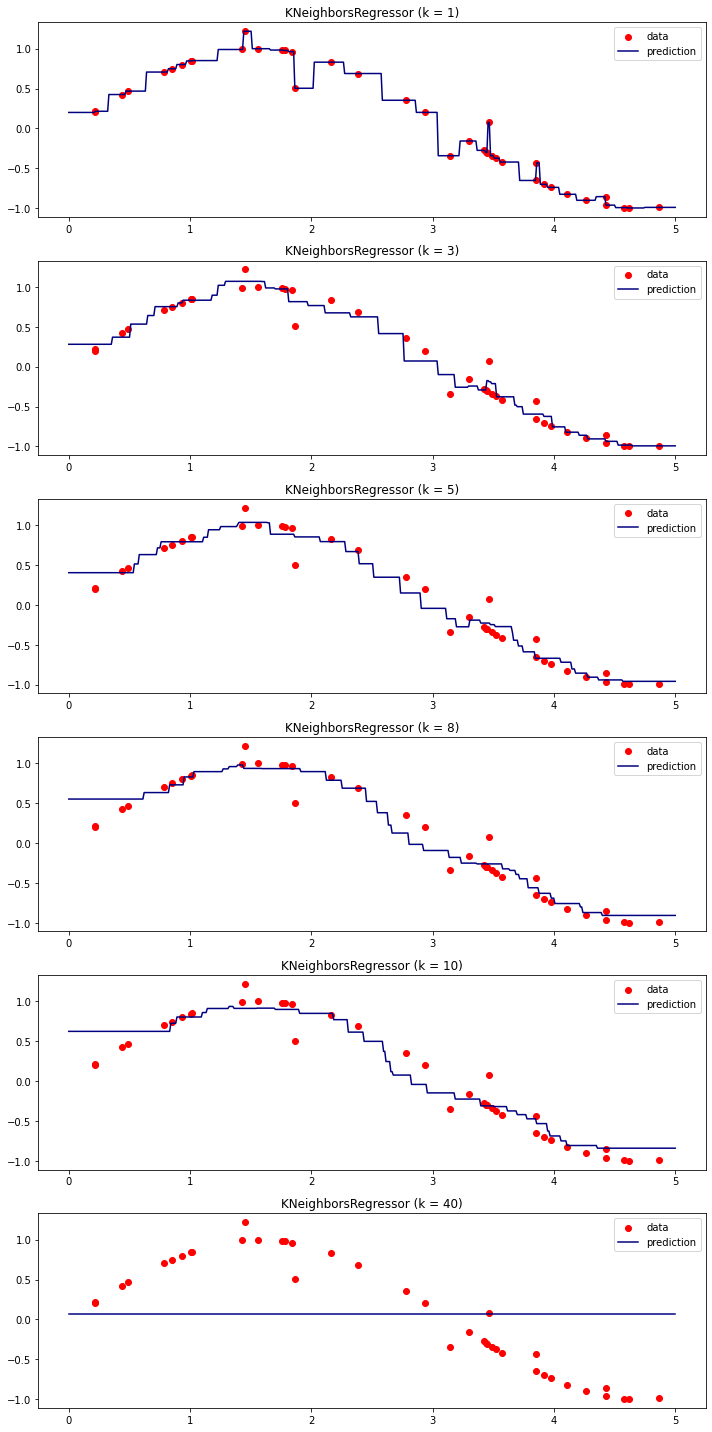

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# 随机生成40个(0, 1)之前的数，乘以5，再进行升序
X = np.sort(5 * np.random.rand(40, 1), axis=0)
# 创建[0, 5]之间的500个数的等差数列, 作为测试数据
T = np.linspace(0, 5, 500)[:, np.newaxis]
# 使用sin函数得到y值，并拉伸到一维
y = np.sin(X).ravel()
# Add noise to targets[y值增加噪声]
y[::5] += 1 * (0.5 - np.random.rand(8))

### Fit Regression Model
n_neighbors = [1, 3, 5, 8, 10, 40] # 多个不同的K值比较
plt.figure(figsize=(10,20))
for i, k in enumerate(n_neighbors):
    # 默认使用加权平均进行计算predictor
    clf = KNeighborsRegressor(n_neighbors=k, p=2, metric="minkowski")
    # 训练
    clf.fit(X, y)
    # 预测
    y_ = clf.predict(T)
    plt.subplot(6, 1, i + 1)
    plt.scatter(X, y, color='red', label='data')
    plt.plot(T, y_, color='navy', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i)" % (k))

plt.tight_layout()
plt.show()


#### 模型分析
K=1，预测结果只和最近的一个训练样本相关，K很小时发生过拟合；

K=40，预测结果和最近的40个训练样本相关，使用所有样本的均值，K过大时发生欠拟合

一般情况下，使用knn的时候，根据数据规模我们会从[3, 20]之间进行尝试。

#### 3.2.2 Classification

In [17]:
import numpy as np
from sklearn import datasets
# import KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

X = iris.data
y = iris.target
# train:test = 8:2
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=.2)

### Train
clf = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski') # Lp=2,欧氏距离
clf.fit(X_tr, y_tr)

### Test
y_pred = clf.predict(X_te)
acc = sum(y_pred == y_te) / y_pred.shape[0]
print("预测的准确率ACC: %.3f" % acc)

预测的准确率ACC: 0.933


C:\Users\hack_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


#### 3.2.3 Fill NaN + Classification

In [18]:
!wget https://tianchi-media.oss-cn-beijing.aliyuncs.com/DSW/3K/horse-colic.csv
!wget https://tianchi-media.oss-cn-beijing.aliyuncs.com/DSW/3K/horse-colic.names

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [19]:
import numpy as np
import pandas as pd
# KNN 数据空值填充
from sklearn.impute import KNNImputer
# calculate Euclidean dist with NaN
from sklearn.metrics.pairwise import nan_euclidean_distances

from sklearn.model_selection import cross_val_score
#KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [20]:
### KNNImputer Fill NaNs
### 使用KNNImputer进行空值填充，KNNImputer填充的原来很简单，计算每个样本最近的k个样本，进行空值填充。

X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
print(X)
imputer = KNNImputer(n_neighbors=2, metric='nan_euclidean')
imputer.fit_transform(X)

[[1, 2, nan], [3, 4, 3], [nan, 6, 5], [8, 8, 7]]


array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

In [21]:
nan_euclidean_distances([[np.nan, 6, 5], [3, 4, 3]], [[3, 4, 3], [1, 2, np.nan], [8, 8, 7]])

array([[3.46410162, 6.92820323, 3.46410162],
       [0.        , 3.46410162, 7.54983444]])

In [22]:
# Load dataset & Fill NaN
input_file = "./horse-colic.csv"
df_data = pd.read_csv(input_file, header=None, na_values='?')

# 得到训练数据和label, 第23列表示是否发生病变, 1: 表示Yes; 2: 表示No. 
data = df_data.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]

# Check NaN
for i in range(df_data.shape[1]):
    n_miss = df_data[[i]].isnull().sum()
    perc = n_miss / df_data.shape[0] * 100
    if n_miss.values[0] > 0:
        print('>Feat: %d, Missing: %d, Missing ratio: (%.2f%%)' % (i, n_miss, perc))

# 查看NaN总数
print('KNNImputer before Missing: %d' % sum(np.isnan(X).flatten()))
# 定义 knnimputer
imputer = KNNImputer()
# 填充数据集中的空值
imputer.fit(X)
# 转换数据集
Xtrans = imputer.transform(X)
# 转换后的数据集的空值
print('KNNImputer after Missing: %d' % sum(np.isnan(Xtrans).flatten()))


>Feat: 0, Missing: 1, Missing ratio: (0.33%)
>Feat: 3, Missing: 60, Missing ratio: (20.00%)
>Feat: 4, Missing: 24, Missing ratio: (8.00%)
>Feat: 5, Missing: 58, Missing ratio: (19.33%)
>Feat: 6, Missing: 56, Missing ratio: (18.67%)
>Feat: 7, Missing: 69, Missing ratio: (23.00%)
>Feat: 8, Missing: 47, Missing ratio: (15.67%)
>Feat: 9, Missing: 32, Missing ratio: (10.67%)
>Feat: 10, Missing: 55, Missing ratio: (18.33%)
>Feat: 11, Missing: 44, Missing ratio: (14.67%)
>Feat: 12, Missing: 56, Missing ratio: (18.67%)
>Feat: 13, Missing: 104, Missing ratio: (34.67%)
>Feat: 14, Missing: 106, Missing ratio: (35.33%)
>Feat: 15, Missing: 247, Missing ratio: (82.33%)
>Feat: 16, Missing: 102, Missing ratio: (34.00%)
>Feat: 17, Missing: 118, Missing ratio: (39.33%)
>Feat: 18, Missing: 29, Missing ratio: (9.67%)
>Feat: 19, Missing: 33, Missing ratio: (11.00%)
>Feat: 20, Missing: 165, Missing ratio: (55.00%)
>Feat: 21, Missing: 198, Missing ratio: (66.00%)
>Feat: 22, Missing: 1, Missing ratio: (0.33%)

>k: 1, Acc Mean: 0.816, Std: 0.046
>k: 2, Acc Mean: 0.812, Std: 0.040
>k: 3, Acc Mean: 0.798, Std: 0.042
>k: 4, Acc Mean: 0.825, Std: 0.045
>k: 5, Acc Mean: 0.816, Std: 0.042
>k: 6, Acc Mean: 0.815, Std: 0.056
>k: 7, Acc Mean: 0.812, Std: 0.042
>k: 8, Acc Mean: 0.820, Std: 0.035
>k: 9, Acc Mean: 0.848, Std: 0.039
>k: 10, Acc Mean: 0.808, Std: 0.052
>k: 15, Acc Mean: 0.825, Std: 0.029
>k: 16, Acc Mean: 0.827, Std: 0.055
>k: 18, Acc Mean: 0.802, Std: 0.059
>k: 20, Acc Mean: 0.825, Std: 0.039
>k: 21, Acc Mean: 0.813, Std: 0.062


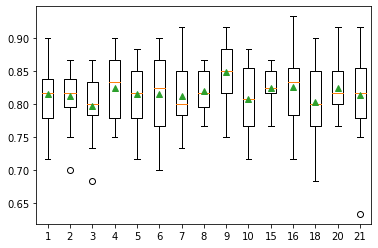

In [28]:
#### Pipeline 
# data -> KNNImputer -> KNN
import warnings

warnings.filterwarnings('ignore')

results = list()
strategies = [str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16, 18, 20, 21]]
for s in strategies:
    pipe = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=int(s))), ('model',KNeighborsClassifier())])
    # 数据多次随机划分取平均得分
    scores = []
    for k in range(20):
        X_tr, X_te, y_tr, y_te = train_test_split(Xtrans, y, test_size=0.2)
        pipe.fit(X_tr, y_tr)
        score = pipe.score(X_te, y_te)
        scores.append(score)
    results.append(np.array(scores))
    print('>k: %s, Acc Mean: %.3f, Std: %.3f' % (s, np.mean(scores), np.std(scores)))
# print(results)
# plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

我们的实验是每个k值下，随机切分20次数据, 从上述的图片中, 根据k值的增加，我们的测试准确率会有先上升再下降再上升的过程。 [3, 5]之间是一个很好的取值，上文我们提到，k很小的时候会发生过拟合，k很大时候会发生欠拟合，当遇到第一下降节点，此时我们可以简单认为不在发生过拟合，取当前的k值即可。